<a href="https://colab.research.google.com/github/NeelTiwary/Ampli/blob/main/FreqSet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

neeltiwary_dataset1_path = kagglehub.dataset_download('neeltiwary/dataset1')
neeltiwary_timesnewroman_path = kagglehub.dataset_download('neeltiwary/timesnewroman')
neeltiwary_times_new_roman_other_default_1_path = kagglehub.model_download('neeltiwary/times-new-roman/Other/default/1')

print('Data source import complete.')


Epoch 1/50 | Loss: 0.2361 | Train F1: 0.1550 | Train Acc (≤1% tol): 0.0813
Epoch 2/50 | Loss: 0.0330 | Train F1: 0.7458 | Train Acc (≤1% tol): 0.6144
Epoch 3/50 | Loss: 0.0248 | Train F1: 0.8359 | Train Acc (≤1% tol): 0.8150
Epoch 4/50 | Loss: 0.0222 | Train F1: 0.8568 | Train Acc (≤1% tol): 0.8750
Epoch 5/50 | Loss: 0.0208 | Train F1: 0.8721 | Train Acc (≤1% tol): 0.9100
Epoch 6/50 | Loss: 0.0193 | Train F1: 0.8782 | Train Acc (≤1% tol): 0.9131
Epoch 7/50 | Loss: 0.0181 | Train F1: 0.8803 | Train Acc (≤1% tol): 0.9087
Epoch 8/50 | Loss: 0.0171 | Train F1: 0.8882 | Train Acc (≤1% tol): 0.9363
Epoch 9/50 | Loss: 0.0163 | Train F1: 0.8908 | Train Acc (≤1% tol): 0.9363
Epoch 10/50 | Loss: 0.0155 | Train F1: 0.8929 | Train Acc (≤1% tol): 0.9337
Epoch 11/50 | Loss: 0.0146 | Train F1: 0.8999 | Train Acc (≤1% tol): 0.9581
Epoch 12/50 | Loss: 0.0139 | Train F1: 0.8995 | Train Acc (≤1% tol): 0.9487
Epoch 13/50 | Loss: 0.0132 | Train F1: 0.9005 | Train Acc (≤1% tol): 0.9500
Epoch 14/50 | Loss: 0

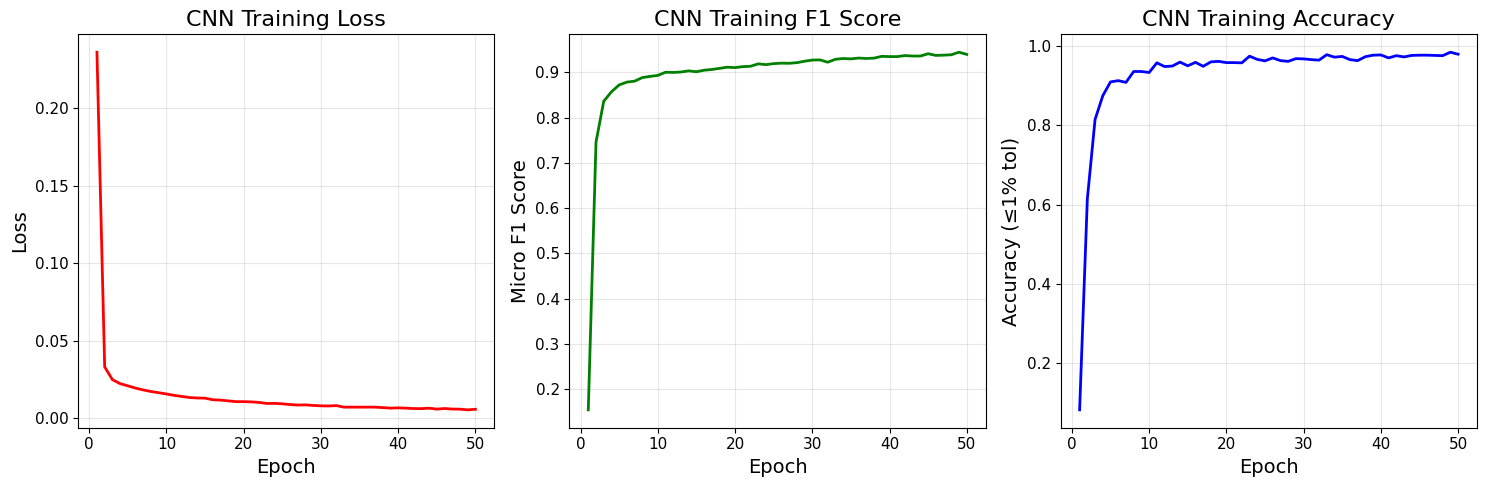

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Load and preprocess data
# ----------------------
amplitude_df = pd.read_csv("/kaggle/input/dataset1/all_signals_1000_1.csv", header=None)
frequency_df = pd.read_csv("/kaggle/input/dataset1/all_frequencies_1000_1.csv", header=None)
X = amplitude_df.iloc[:, 1:].values.astype(np.float32)
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)
y_raw = frequency_df.iloc[:, 1:].values
label_sets = [list(set(row[row != 0])) for row in y_raw]
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(label_sets)
X_tensor = torch.tensor(X).unsqueeze(1)
y_tensor = torch.tensor(y).float()
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# ----------------------
# Define CNN model
# ----------------------
class CNNClassifier(nn.Module):
    def __init__(self, input_length, num_labels):
        super(CNNClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.flatten_dim = (input_length // 4) * 64
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# ----------------------
# Training
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_CNN = CNNClassifier(input_length=X.shape[1], num_labels=y.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_CNN.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 50
cnn_train_losses, cnn_train_f1_scores, cnn_train_accuracies = [], [], []

for epoch in range(num_epochs):
    model_CNN.train()
    total_loss = 0
    all_preds, all_labels = [], []
    correct, total_samples = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_CNN.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().detach().numpy())
        all_labels.extend(labels.cpu().detach().numpy())
        mismatches = (preds != labels).sum(dim=1)
        allowed_error = max(1, int(0.01 * labels.size(1)))
        correct += (mismatches <= allowed_error).sum().item()
        total_samples += labels.size(0)
    avg_loss = total_loss / len(train_loader)
    train_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    train_acc = correct / total_samples if total_samples > 0 else 0
    cnn_train_losses.append(avg_loss)
    cnn_train_f1_scores.append(train_f1)
    cnn_train_accuracies.append(train_acc)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Train F1: {train_f1:.4f} | Train Acc (≤1% tol): {train_acc:.4f}")

# ----------------------
# Final Testing Evaluation
# ----------------------
model_CNN.eval()
all_preds_CNN, all_labels_CNN, comparison_rows_CNN = [], [], []
correct, total_samples = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_CNN(inputs)
        preds = (outputs > 0.5).float()
        all_preds_CNN.extend(preds.cpu().numpy())
        all_labels_CNN.extend(labels.cpu().numpy())
        for p, t in zip(preds, labels):
            pred_labels = [mlb.classes_[i] for i, v in enumerate(p) if v == 1]
            true_labels = [mlb.classes_[i] for i, v in enumerate(t) if v == 1]
            comparison_rows_CNN.append({"Predicted": pred_labels, "True": true_labels})
        mismatches = (preds != labels).sum(dim=1)
        allowed_error = max(1, int(0.01 * labels.size(1)))
        correct += (mismatches <= allowed_error).sum().item()
        total_samples += labels.size(0)
test_f1_CNN = f1_score(all_labels_CNN, all_preds_CNN, average='micro', zero_division=0)
test_acc_CNN = correct / total_samples if total_samples > 0 else 0
print(f"\nFinal Test Micro F1 Score (CNN): {test_f1_CNN:.4f}")
print(f"Final Test Accuracy (≤1% tol) (CNN): {test_acc_CNN:.4f}")
print("\nClassification Report (CNN):")
print(classification_report(all_labels_CNN, all_preds_CNN, target_names=[str(l) for l in mlb.classes_], zero_division=0))

# ----------------------
# Save Predictions
# ----------------------
pd.DataFrame(comparison_rows_CNN).to_csv("cnn_prediction_vs_ground_truth_test.csv", index=False)

# ----------------------
# Plot Training Curves
# ----------------------
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), cnn_train_losses, color='red', linewidth=2)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("CNN Training Loss"); plt.grid(True, alpha=0.3)
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), cnn_train_f1_scores, color='green', linewidth=2)
plt.xlabel("Epoch"); plt.ylabel("Micro F1 Score"); plt.title("CNN Training F1 Score"); plt.grid(True, alpha=0.3)
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), cnn_train_accuracies, color='blue', linewidth=2)
plt.xlabel("Epoch"); plt.ylabel("Accuracy (≤1% tol)"); plt.title("CNN Training Accuracy"); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("cnn_training_curves.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Using device: cpu
SelfONN parameters: 1,691,478
Epoch 1/50 | Loss: 0.2688 | Train F1: 0.1111 | Train Acc (≤1% tol): 0.0494
Epoch 2/50 | Loss: 0.0365 | Train F1: 0.6970 | Train Acc (≤1% tol): 0.4975
Epoch 3/50 | Loss: 0.0264 | Train F1: 0.8253 | Train Acc (≤1% tol): 0.7875
Epoch 4/50 | Loss: 0.0236 | Train F1: 0.8553 | Train Acc (≤1% tol): 0.8575
Epoch 5/50 | Loss: 0.0221 | Train F1: 0.8645 | Train Acc (≤1% tol): 0.8806
Epoch 6/50 | Loss: 0.0208 | Train F1: 0.8691 | Train Acc (≤1% tol): 0.8862
Epoch 7/50 | Loss: 0.0197 | Train F1: 0.8770 | Train Acc (≤1% tol): 0.9106
Epoch 8/50 | Loss: 0.0184 | Train F1: 0.8843 | Train Acc (≤1% tol): 0.9175
Epoch 9/50 | Loss: 0.0175 | Train F1: 0.8858 | Train Acc (≤1% tol): 0.9237
Epoch 10/50 | Loss: 0.0166 | Train F1: 0.8883 | Train Acc (≤1% tol): 0.9256
Epoch 11/50 | Loss: 0.0157 | Train F1: 0.8925 | Train Acc (≤1% tol): 0.9313
Epoch 12/50 | Loss: 0.0147 | Train F1: 0.8961 | Train Acc (≤1% tol): 0.9331
Epoch 13/50 | Loss: 0.0146 | Train F1: 0.8952 | T

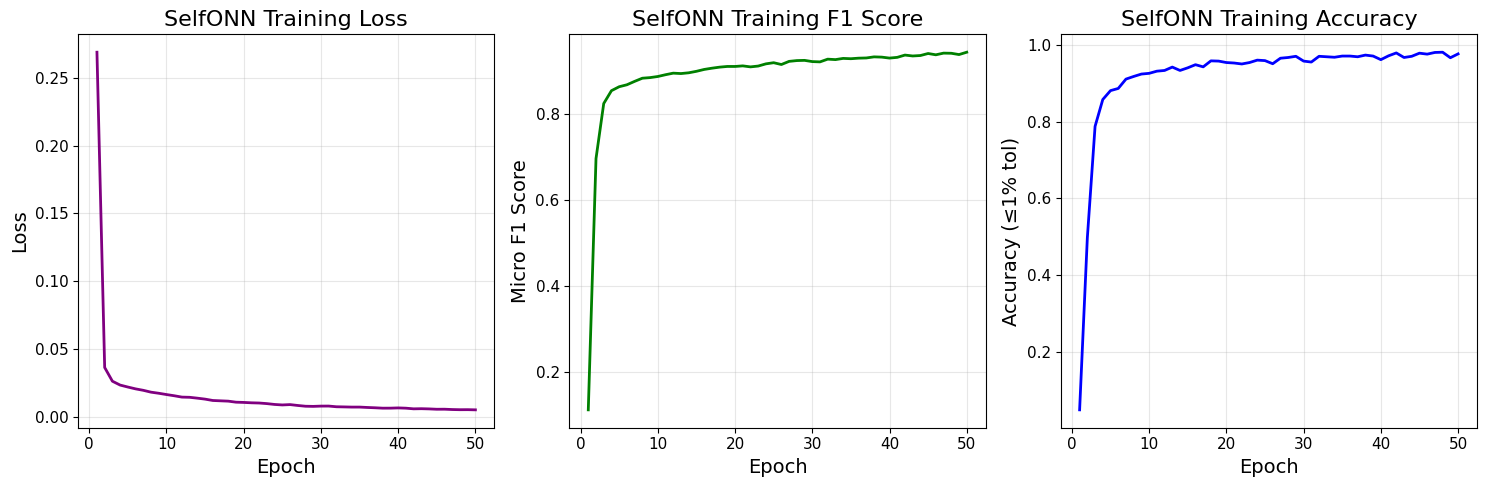

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 📂 Load Data
amplitude_df = pd.read_csv("/kaggle/input/dataset1/all_signals_1000_1.csv", header=None)
frequency_df = pd.read_csv("/kaggle/input/dataset1/all_frequencies_1000_1.csv", header=None)
X = amplitude_df.iloc[:, 1:].values.astype(np.float32)
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)
y_raw = frequency_df.iloc[:, 1:].values
label_sets = [list(set(row[row != 0])) for row in y_raw]
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(label_sets)
X_tensor = torch.tensor(X).unsqueeze(1)
y_tensor = torch.tensor(y).float()
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 🧱 SelfONN Layer (CORRECTED)
class SelfONNLayer1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, order=3, stride=1, padding=0):
        super().__init__()
        self.order = order
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = nn.ParameterList([
            nn.Parameter(torch.randn(out_channels, in_channels, kernel_size))
            for _ in range(order)
        ])
        self.alphas = nn.ParameterList([
            nn.Parameter(torch.ones(1)) for _ in range(order)
        ])
        self.betas = nn.ParameterList([
            nn.Parameter(torch.zeros(1)) for _ in range(order)
        ])
        self.bias = nn.Parameter(torch.zeros(out_channels))
        for i in range(order):
            nn.init.kaiming_normal_(self.weights[i], mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        batch_size, channels, length = x.shape
        out = 0
        for k in range(self.order):
            if k == 0:
                nonlinear_x = x
            elif k == 1:
                nonlinear_x = x * torch.sigmoid(x)
            elif k == 2:
                nonlinear_x = torch.sin(self.alphas[k] * x + self.betas[k])
            else:
                nonlinear_x = torch.exp(-x.pow(2))
            conv_out = nn.functional.conv1d(
                nonlinear_x, self.weights[k], bias=None,
                stride=self.stride, padding=self.padding
            )
            out += conv_out
        out += self.bias.view(1, -1, 1)
        return out

# 🧱 SelfONN Classifier
class SelfONNClassifier(nn.Module):
    def __init__(self, input_length, num_labels, order=3):
        super().__init__()
        self.conv = nn.Sequential(
            SelfONNLayer1D(1, 32, kernel_size=5, order=7, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            SelfONNLayer1D(32, 64, kernel_size=3, order=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, input_length)
            dummy_output = self.conv(dummy_input)
            self.flatten_dim = dummy_output.numel()
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# ⚙️ Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model_SelfONN = SelfONNClassifier(input_length=X.shape[1], num_labels=y.shape[1]).to(device)
print(f"SelfONN parameters: {sum(p.numel() for p in model_SelfONN.parameters()):,}")
criterion = nn.BCELoss()
optimizer = optim.Adam(model_SelfONN.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 50
sonn_train_losses, sonn_train_f1_scores, sonn_train_accuracies = [], [], []
start_time = time.time()

# 🏋️ Training Loop
for epoch in range(num_epochs):
    model_SelfONN.train()
    total_loss = 0
    all_preds, all_labels = [], []
    correct, total_samples = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_SelfONN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_SelfONN.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().detach().numpy())
        all_labels.extend(labels.cpu().detach().numpy())
        mismatches = (preds != labels).sum(dim=1)
        allowed_errors = max(1, int(0.01 * labels.size(1)))
        correct += (mismatches <= allowed_errors).sum().item()
        total_samples += labels.size(0)
    avg_loss = total_loss / len(train_loader)
    train_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    train_acc = correct / total_samples if total_samples > 0 else 0
    sonn_train_losses.append(avg_loss)
    sonn_train_f1_scores.append(train_f1)
    sonn_train_accuracies.append(train_acc)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Train F1: {train_f1:.4f} | Train Acc (≤1% tol): {train_acc:.4f}")
end_time = time.time()

# 🧪 Final Testing
model_SelfONN.eval()
all_preds_SelfONN, all_labels_SelfONN, comparison_rows_SelfONN = [], [], []
correct, total_samples = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_SelfONN(inputs)
        preds = (outputs > 0.5).float()
        all_preds_SelfONN.extend(preds.cpu().numpy())
        all_labels_SelfONN.extend(labels.cpu().numpy())
        for p, t in zip(preds, labels):
            pred_labels = [mlb.classes_[i] for i, v in enumerate(p) if v == 1]
            true_labels = [mlb.classes_[i] for i, v in enumerate(t) if v == 1]
            comparison_rows_SelfONN.append({"Predicted": pred_labels, "True": true_labels})
        mismatches = (preds != labels).sum(dim=1)
        allowed_errors = max(1, int(0.01 * labels.size(1)))
        correct += (mismatches <= allowed_errors).sum().item()
        total_samples += labels.size(0)
test_f1_SelfONN = f1_score(all_labels_SelfONN, all_preds_SelfONN, average='micro', zero_division=0)
test_acc_SelfONN = correct / total_samples if total_samples > 0 else 0
print(f"\nFinal Test Micro F1 Score (SelfONN): {test_f1_SelfONN:.4f}")
print(f"Final Test Accuracy (≤1% tol) (SelfONN): {test_acc_SelfONN:.4f}")
print(f"Total Training Time: {end_time - start_time:.2f} seconds\n")
print("Classification Report (SelfONN):\n")
print(classification_report(all_labels_SelfONN, all_preds_SelfONN,
                           target_names=[str(l) for l in mlb.classes_], zero_division=0))

# Save Predictions
pd.DataFrame(comparison_rows_SelfONN).to_csv("selfonn_prediction_vs_ground_truth_test.csv", index=False)

# Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), sonn_train_losses, color='purple', linewidth=2)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("SelfONN Training Loss"); plt.grid(True, alpha=0.3)
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), sonn_train_f1_scores, color='green', linewidth=2)
plt.xlabel("Epoch"); plt.ylabel("Micro F1 Score"); plt.title("SelfONN Training F1 Score"); plt.grid(True, alpha=0.3)
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), sonn_train_accuracies, color='blue', linewidth=2)
plt.xlabel("Epoch"); plt.ylabel("Accuracy (≤1% tol)"); plt.title("SelfONN Training Accuracy"); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("selfonn_training_curves.png", dpi=300, bbox_inches='tight')
plt.show()

Dataset info: (2000, 9) samples, 258 classes
Class distribution: [1584    3    5    4    5    5   10    6    9    6    3    6    8    5
    7    4    8    4    6   10    5    8    5   11    4   11    8    7
    9    8   12    7 1434    6    5    7    7    8    8    3    1    7
    8    9    7    4    3    4    2    3    3    6    3   12    7    3
    4    8    8    6    4    9    8    8 1269    2    9    7    6    1
    8    8    3    9    4    5    2    3    3    5    2    4    7    4
    7    5    6    6    5    3    3    7    3    7    6    4 1072    4
    5    3    5    4    3    2    4    5    5    1    5    6    5    3
    5    1    7    4    5    3    2    4    1    4    5    3    4    6
    3    5  897    3    4    3    2    5    8    3    3    6    4    3
    4    3    2    5    3    3    3    4    3    4    3    2    2    2
    3    5    1    3  706    5    1    3    5    1    2    1    2    2
    7    3    4    1    2    5    2    2    6    3    5    3    4    6
    3    6  

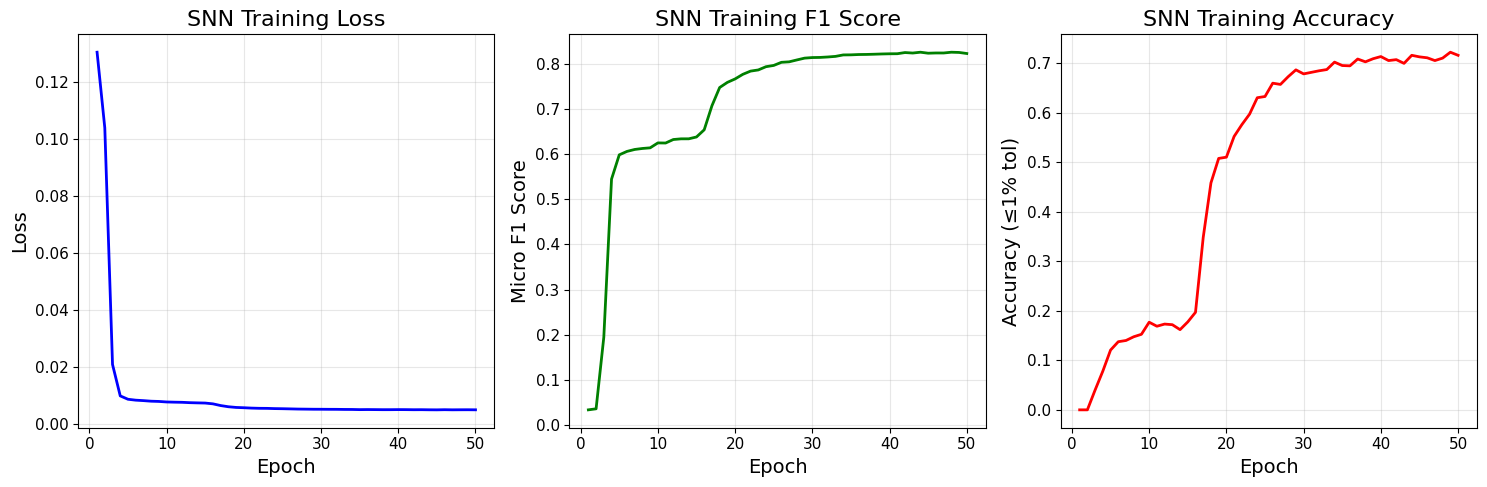

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 📂 Load and preprocess data
amplitude_df = pd.read_csv("/kaggle/input/dataset1/all_frequencies_1000_1.csv", header=None)
frequency_df = pd.read_csv("/kaggle/input/dataset1/all_frequencies_1000_1.csv", header=None)
X = amplitude_df.iloc[:, 1:].values.astype(np.float32)
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)
y_raw = frequency_df.iloc[:, 1:].values
label_sets = [list(set(row[row != 0])) for row in y_raw]
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(label_sets)
X_tensor = torch.tensor(X).unsqueeze(1)
y_tensor = torch.tensor(y).float()
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

print(f"Dataset info: {X.shape} samples, {y.shape[1]} classes")
print(f"Class distribution: {y.sum(axis=0)}")

# 🧱 SIMPLIFIED LIF Neuron (Better for training)
class LIFNeuron(nn.Module):
    def __init__(self, threshold=0.5, decay=0.9):
        super().__init__()
        self.threshold = threshold
        self.decay = decay

    def forward(self, x):
        batch_size, channels, time_steps = x.size()
        membrane_potential = torch.zeros(batch_size, channels, device=x.device)
        spike_outputs = []

        for t in range(time_steps):
            input_current = x[:, :, t]
            membrane_potential = self.decay * membrane_potential + input_current

            # Spike generation with gradient-friendly approach
            spikes = torch.sigmoid(membrane_potential - self.threshold)

            # Soft reset
            membrane_potential = membrane_potential * (1 - spikes.detach())

            spike_outputs.append(spikes.unsqueeze(-1))

        return torch.cat(spike_outputs, dim=-1)

# 🧱 SIMPLIFIED SNN Classifier (Better convergence)
class SNNClassifier(nn.Module):
    def __init__(self, input_length, num_labels):
        super().__init__()

        # Simpler architecture for better training
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=15, padding=7),
            LIFNeuron(threshold=0.3, decay=0.95),
            nn.AvgPool1d(2),

            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            LIFNeuron(threshold=0.3, decay=0.95),
            nn.AvgPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            LIFNeuron(threshold=0.3, decay=0.95),
            nn.AdaptiveAvgPool1d(8),
        )

        # Calculate flattened dimension
        self._calculate_flatten_dim(input_length)

        # Simpler classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_labels),
            nn.Sigmoid()
        )

    def _calculate_flatten_dim(self, input_length):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_length)
            dummy_output = self.conv_layers(dummy_input)
            self.flatten_dim = dummy_output.numel()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# ⚙️ Improved Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_SNN = SNNClassifier(input_length=X_tensor.shape[2], num_labels=y_tensor.shape[1]).to(device)
print(f"SNN parameters: {sum(p.numel() for p in model_SNN.parameters()):,}")

# 🔧 CRITICAL IMPROVEMENTS:
# 1. Focal Loss for class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

# Use Focal Loss instead of BCELoss
criterion = FocalLoss(alpha=0.75, gamma=2.0)

# 2. Better optimizer with warmup
optimizer = optim.AdamW(model_SNN.parameters(), lr=0.001, weight_decay=1e-4)

# 3. Learning rate scheduler with warmup
def get_lr_scheduler(optimizer, num_epochs):
    warmup_epochs = 5
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1, warmup_epochs))
        else:
            return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(optimizer, num_epochs=50)

num_epochs = 50
snn_train_losses, snn_train_f1_scores, snn_train_accuracies = [], [], []
start_time = time.time()

# 🏋️ IMPROVED Training Loop
for epoch in range(num_epochs):
    model_SNN.train()
    total_loss = 0
    all_preds, all_labels = [], []
    correct, total_samples = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_SNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model_SNN.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

        # Convert to binary predictions with adaptive threshold
        preds = (outputs > 0.3).float()  # Lower threshold for multi-label

        all_preds.extend(preds.cpu().detach().numpy())
        all_labels.extend(labels.cpu().detach().numpy())

        # Calculate accuracy with tolerance
        mismatches = (preds != labels).sum(dim=1)
        allowed_errors = max(1, int(0.01 * labels.size(1)))
        correct += (mismatches <= allowed_errors).sum().item()
        total_samples += labels.size(0)

    # Update learning rate
    scheduler.step()

    # Calculate metrics
    avg_loss = total_loss / len(train_loader)
    train_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    train_acc = correct / total_samples if total_samples > 0 else 0

    snn_train_losses.append(avg_loss)
    snn_train_f1_scores.append(train_f1)
    snn_train_accuracies.append(train_acc)

    # Print class-wise predictions to debug
    preds_array = np.array(all_preds)
    preds_sum = preds_array.sum(axis=0)
    active_classes = np.sum(preds_sum > 0)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Train F1: {train_f1:.4f} | Train Acc: {train_acc:.4f} | Active Classes: {active_classes}/{y.shape[1]} | LR: {scheduler.get_last_lr()[0]:.6f}")

end_time = time.time()

# 🧪 Final Testing
model_SNN.eval()
all_preds_SNN, all_labels_SNN = [], []
correct, total_samples = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_SNN(inputs)
        preds = (outputs > 0.3).float()  # Same threshold as training

        all_preds_SNN.extend(preds.cpu().numpy())
        all_labels_SNN.extend(labels.cpu().numpy())

        mismatches = (preds != labels).sum(dim=1)
        allowed_errors = max(1, int(0.01 * labels.size(1)))
        correct += (mismatches <= allowed_errors).sum().item()
        total_samples += labels.size(0)

test_f1_SNN = f1_score(all_labels_SNN, all_preds_SNN, average='micro', zero_division=0)
test_acc_SNN = correct / total_samples if total_samples > 0 else 0

print(f"\nFinal Test Micro F1 Score (SNN): {test_f1_SNN:.4f}")
print(f"Final Test Accuracy (≤1% tol) (SNN): {test_acc_SNN:.4f}")
print(f"Total Training Time: {end_time - start_time:.2f} seconds\n")

# Print class distribution in predictions
preds_array = np.array(all_preds_SNN)
preds_sum = preds_array.sum(axis=0)
print("Predicted class distribution:")
for i, count in enumerate(preds_sum):
    if count > 0:
        print(f"  Class {mlb.classes_[i]}: {int(count)} predictions")

print("\nClassification Report (SNN):")
print(classification_report(all_labels_SNN, all_preds_SNN,
                           target_names=[str(l) for l in mlb.classes_], zero_division=0))

# Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), snn_train_losses, color='blue', linewidth=2)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("SNN Training Loss"); plt.grid(True, alpha=0.3)
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), snn_train_f1_scores, color='green', linewidth=2)
plt.xlabel("Epoch"); plt.ylabel("Micro F1 Score"); plt.title("SNN Training F1 Score"); plt.grid(True, alpha=0.3)
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), snn_train_accuracies, color='red', linewidth=2)
plt.xlabel("Epoch"); plt.ylabel("Accuracy (≤1% tol)"); plt.title("SNN Training Accuracy"); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("snn_training_curves_improved.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
amplitude_df.shape

(2000, 10)

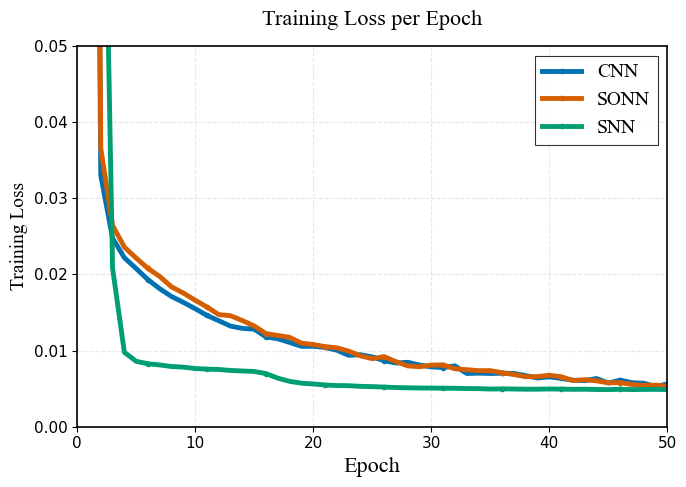

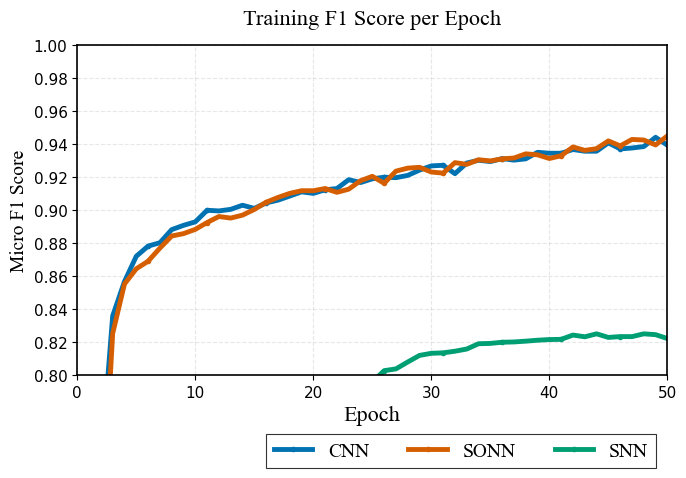


🏆 TOPSIS Ranking:

  Model  Accuracy  F1 Score  TOPSIS Score  Rank
0   CNN     0.985  0.924775      1.000000     1
1  SONN     0.970  0.916921      0.957316     2
2   SNN     0.605  0.815724      0.000000     3


Model,Accuracy,F1 Score,TOPSIS Score,Rank
CNN,0.985000,0.924775,1.0000,1
SONN,0.970000,0.916921,0.9573,2
SNN,0.605000,0.815724,0.0000,3


ValueError: 'cellColours' must have 4 rows

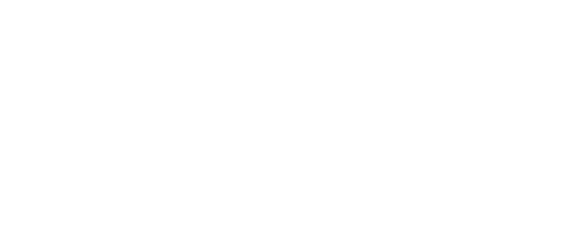

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
from IPython.display import display

def run_topsis(df, weights, impacts):
    decision_matrix = df.iloc[:, 1:].values.astype(np.float64)
    norm = np.linalg.norm(decision_matrix, axis=0)
    norm[norm == 0] = 1e-10
    norm_matrix = decision_matrix / norm
    weights = np.array(weights)
    weighted_matrix = norm_matrix * weights
    ideal, negative_ideal = [], []
    for i, impact in enumerate(impacts):
        if impact == '+':
            ideal.append(np.max(weighted_matrix[:, i]))
            negative_ideal.append(np.min(weighted_matrix[:, i]))
        else:
            ideal.append(np.min(weighted_matrix[:, i]))
            negative_ideal.append(np.max(weighted_matrix[:, i]))
    ideal = np.array(ideal)
    negative_ideal = np.array(negative_ideal)
    dist_ideal = np.linalg.norm(weighted_matrix - ideal, axis=1)
    dist_negative = np.linalg.norm(weighted_matrix - negative_ideal, axis=1)
    denom = dist_ideal + dist_negative
    denom[denom == 0] = 1e-10
    closeness = dist_negative / denom
    df['TOPSIS Score'] = closeness
    df['Rank'] = df['TOPSIS Score'].rank(ascending=False, method='min').astype(int)
    df = df.sort_values(by='TOPSIS Score', ascending=False).reset_index(drop=True)
    return df

# IEEE Q1 Style
font_path = "/kaggle/input/times-new-roman/other/default/1/Times New Roman Font.ttf"
plt.rcParams.update({
    'font.family': ['Times New Roman'], 'font.size': 11,
    'axes.labelsize': 14, 'axes.titlesize': 16,
    'legend.fontsize': 13, 'figure.titlesize': 18,
    'savefig.dpi': 300, 'savefig.bbox': 'tight',
    'pdf.fonttype': 42,
})

try:
    tnr_font = fm.FontProperties(fname=font_path, size=14)
    tnr_bold_font = fm.FontProperties(fname=font_path, size=16, weight='bold')
except FileNotFoundError:
    print("Warning: Times New Roman font file not found. Using default Times New Roman.")
    plt.rcParams['font.family'] = 'Times New Roman'
    tnr_font = fm.FontProperties(family='Times New Roman', size=14)
    tnr_bold_font = fm.FontProperties(family='Times New Roman', size=16, weight='bold')

epochs = np.arange(1, 51)

# 🎨 IEEE Colorblind Palette with CNN, SONN, SNN labels
colors = ['#0072B2', '#D55E00', '#009E73']  # Blue=CNN, Orange=SONN, Green=SNN

# Graph 1: Loss (ZOOMED 0 → 0.05)
fig = plt.figure(figsize=(7, 5))
gs = GridSpec(1, 1, figure=fig)
ax = fig.add_subplot(gs[0, 0])

# 📊 Plot with CNN, SONN, SNN labels
ax.plot(epochs, cnn_train_losses, label='CNN', color=colors[0], linewidth=3.5, marker='o', markersize=3, markevery=5)
ax.plot(epochs, sonn_train_losses, label='SONN', color=colors[1], linewidth=3.5, marker='o', markersize=3, markevery=5)
ax.plot(epochs, snn_train_losses, label='SNN', color=colors[2], linewidth=3.5, marker='o', markersize=3, markevery=5)

ax.set_xlabel('Epoch', fontproperties=tnr_bold_font)
ax.set_ylabel('Training Loss', fontproperties=tnr_font)
ax.set_title('Training Loss per Epoch', fontproperties=tnr_bold_font, pad=15)
ax.set_xlim(1, 50)
ax.set_ylim(0, 0.05)
ax.set_xticks(np.arange(0, 51, 10))
ax.set_yticks(np.arange(0, 0.051, 0.01))
ax.grid(True, linestyle='--', alpha=0.3)

# BIG LEGEND
legend = ax.legend(prop=tnr_font, loc='upper right', frameon=True, fancybox=False, edgecolor='black')
legend.get_frame().set_linewidth(0.8)

for spine in ax.spines.values():
    spine.set_linewidth(1.2)
    spine.set_color('black')

plt.tight_layout()
plt.savefig('ieee_graph1_loss.pdf', format='pdf')
plt.savefig('ieee_graph1_loss.png', format='png')
plt.show()

# Graph 2: F1 (ZOOMED 0.8 → 1.0)
fig2 = plt.figure(figsize=(7, 5))
ax2 = fig2.add_subplot(111)

# 📊 Plot with CNN, SONN, SNN labels
ax2.plot(epochs, cnn_train_f1_scores, label='CNN', color=colors[0], linewidth=3.5, marker='o', markersize=3, markevery=5)
ax2.plot(epochs, sonn_train_f1_scores, label='SONN', color=colors[1], linewidth=3.5, marker='o', markersize=3, markevery=5)
ax2.plot(epochs, snn_train_f1_scores, label='SNN', color=colors[2], linewidth=3.5, marker='o', markersize=3, markevery=5)

ax2.set_xlabel('Epoch', fontproperties=tnr_bold_font)
ax2.set_ylabel('Micro F1 Score', fontproperties=tnr_font)
ax2.set_title('Training F1 Score per Epoch', fontproperties=tnr_bold_font, pad=15)
ax2.set_xlim(1, 50)
ax2.set_ylim(0.8, 1.0)
ax2.set_xticks(np.arange(0, 51, 10))
ax2.set_yticks(np.arange(0.8, 1.01, 0.02))
ax2.grid(True, linestyle='--', alpha=0.3)

# BIG LEGEND (Positioned below, slightly to the right)
legend2 = ax2.legend(prop=tnr_font, loc='upper center', bbox_to_anchor=(0.65, -0.15),
                    frameon=True, fancybox=False, edgecolor='black', ncol=3)
legend2.get_frame().set_linewidth(0.8)

for spine in ax2.spines.values():
    spine.set_linewidth(1.2)
    spine.set_color('black')

plt.tight_layout()
plt.savefig('ieee_graph2_f1.pdf', format='pdf')
plt.savefig('ieee_graph2_f1.png', format='png')
plt.show()

# TOPSIS
cnn_accuracy, cnn_f1 = test_acc_CNN, test_f1_CNN
sonn_accuracy, sonn_f1 = test_acc_SelfONN, test_f1_SelfONN
snn_accuracy, snn_f1 = test_acc_SNN, test_f1_SNN

data = {
    'Model': ['CNN', 'SONN', 'SNN'],  # Consistent order: CNN, SONN, SNN
    'Accuracy': [cnn_accuracy, sonn_accuracy, snn_accuracy],
    'F1 Score': [cnn_f1, sonn_f1, snn_f1],
}
df = pd.DataFrame(data)
weights = [0.5, 0.5]
impacts = ['+', '+']
result_df = run_topsis(df, weights, impacts)

print("\n🏆 TOPSIS Ranking:\n")
print(result_df)

# Styled DataFrame for display
styled_df = result_df.style.set_caption("TOPSIS Model Ranking") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-family', 'Times New Roman'), ('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('font-family', 'Times New Roman'), ('font-weight', 'bold'), ('text-align', 'center'), ('border', '1px solid black'), ('padding', '8px')]},
        {'selector': 'td', 'props': [('font-family', 'Times New Roman'), ('text-align', 'center'), ('border', '1px solid black'), ('padding', '8px')]}
    ]) \
    .set_properties(**{'font-size': '11pt'}) \
    .hide(axis='index') \
    .format({'TOPSIS Score': '{:.4f}', 'Rank': '{:.0f}'})

display(styled_df)

# Table as Figure
fig_table = plt.figure(figsize=(7, 3))
ax_table = fig_table.add_subplot(111)
ax_table.axis('off')

table_data = [result_df.columns.tolist()] + result_df.values.tolist()
table = ax_table.table(cellText=table_data,
                      cellLoc='center',
                      loc='center',
                      colColours=['#f0f0f0'] * len(result_df.columns),
                      cellColours=[['#ffffff'] * len(result_df.columns)] * len(result_df))

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

for (i, j), cell in table.get_celld().items():
    cell.set_text_props(fontfamily='Times New Roman')
    cell.set_edgecolor('black')
    cell.set_linewidth(1)
    if i == 0:
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#f0f0f0')
    cell.set_height(0.1)
    cell.set_text_props(ha='center', va='center')

fig_table.suptitle('TOPSIS Model Ranking', fontsize=12, fontfamily='Times New Roman', fontweight='bold')

plt.savefig('ieee_topsis_table.pdf', format='pdf')
plt.savefig('ieee_topsis_table.png', format='png')
plt.close(fig_table)

print("\n✅ SUCCESS! All files saved:")
print("• ieee_graph1_loss.pdf/png   (ZOOMED: 0→0.05, CNN/SONN/SNN labels)")
print("• ieee_graph2_f1.pdf/png     (ZOOMED: 0.8→1.0, CNN/SONN/SNN labels)")
print("• ieee_topsis_table.pdf/png  (High-resolution)")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
from IPython.display import display

def run_topsis(df, weights, impacts):
    decision_matrix = df.iloc[:, 1:].values.astype(np.float64)
    norm = np.linalg.norm(decision_matrix, axis=0)
    norm[norm == 0] = 1e-10
    norm_matrix = decision_matrix / norm
    weights = np.array(weights)
    weighted_matrix = norm_matrix * weights
    ideal, negative_ideal = [], []
    for i, impact in enumerate(impacts):
        if impact == '+':
            ideal.append(np.max(weighted_matrix[:, i]))
            negative_ideal.append(np.min(weighted_matrix[:, i]))
        else:
            ideal.append(np.min(weighted_matrix[:, i]))
            negative_ideal.append(np.max(weighted_matrix[:, i]))
    ideal = np.array(ideal)
    negative_ideal = np.array(negative_ideal)
    dist_ideal = np.linalg.norm(weighted_matrix - ideal, axis=1)
    dist_negative = np.linalg.norm(weighted_matrix - negative_ideal, axis=1)
    denom = dist_ideal + dist_negative
    denom[denom == 0] = 1e-10
    closeness = dist_negative / denom
    df['TOPSIS Score'] = closeness
    df['Rank'] = df['TOPSIS Score'].rank(ascending=False, method='min').astype(int)
    df = df.sort_values(by='TOPSIS Score', ascending=False).reset_index(drop=True)
    return df

# IEEE Q1 Style
font_path = "/kaggle/input/times-new-roman/other/default/1/Times New Roman Font.ttf"
plt.rcParams.update({
    'font.family': ['Times New Roman'], 'font.size': 11,
    'axes.labelsize': 14, 'axes.titlesize': 16,
    'legend.fontsize': 13, 'figure.titlesize': 18,
    'savefig.dpi': 300, 'savefig.bbox': 'tight',
    'pdf.fonttype': 42,
})

try:
    tnr_font = fm.FontProperties(fname=font_path, size=14)
    tnr_bold_font = fm.FontProperties(fname=font_path, size=16, weight='bold')
except FileNotFoundError:
    print("Warning: Times New Roman font file not found. Using default Times New Roman.")
    plt.rcParams['font.family'] = 'Times New Roman'
    tnr_font = fm.FontProperties(family='Times New Roman', size=14)
    tnr_bold_font = fm.FontProperties(family='Times New Roman', size=16, weight='bold')

epochs = np.arange(1, 51)

# 🎨 IEEE Colorblind Palette with CNN, SONN, SNN labels
colors = ['#0072B2', '#D55E00', '#009E73']  # Blue=CNN, Orange=SONN, Green=SNN

# Graph 1: Loss (ZOOMED 0 → 0.05)
fig = plt.figure(figsize=(7, 5))
gs = GridSpec(1, 1, figure=fig)
ax = fig.add_subplot(gs[0, 0])

# 📊 Plot with CNN, SONN, SNN labels
ax.plot(epochs, cnn_train_losses, label='CNN', color=colors[0], linewidth=3.5, marker='o', markersize=3, markevery=5)
ax.plot(epochs, sonn_train_losses, label='SONN', color=colors[1], linewidth=3.5, marker='o', markersize=3, markevery=5)
ax.plot(epochs, snn_train_losses, label='SNN', color=colors[2], linewidth=3.5, marker='o', markersize=3, markevery=5)

ax.set_xlabel('Epoch', fontproperties=tnr_bold_font)
ax.set_ylabel('Training Loss', fontproperties=tnr_font)
ax.set_title('Training Loss per Epoch', fontproperties=tnr_bold_font, pad=15)
ax.set_xlim(1, 50)
ax.set_ylim(0, 0.05)
ax.set_xticks(np.arange(0, 51, 10))
ax.set_yticks(np.arange(0, 0.051, 0.01))
ax.grid(True, linestyle='--', alpha=0.3)

# BIG LEGEND
legend = ax.legend(prop=tnr_font, loc='upper right', frameon=True, fancybox=False, edgecolor='black')
legend.get_frame().set_linewidth(0.8)

for spine in ax.spines.values():
    spine.set_linewidth(1.2)
    spine.set_color('black')

plt.tight_layout()
plt.savefig('ieee_graph1_loss.pdf', format='pdf')
plt.savefig('ieee_graph1_loss.png', format='png')
plt.show()

# Graph 2: F1 (ZOOMED 0.8 → 1.0)
fig2 = plt.figure(figsize=(7, 5))
ax2 = fig2.add_subplot(111)

# 📊 Plot with CNN, SONN, SNN labels
ax2.plot(epochs, cnn_train_f1_scores, label='CNN', color=colors[0], linewidth=3.5, marker='o', markersize=3, markevery=5)
ax2.plot(epochs, sonn_train_f1_scores, label='SONN', color=colors[1], linewidth=3.5, marker='o', markersize=3, markevery=5)
ax2.plot(epochs, snn_train_f1_scores, label='SNN', color=colors[2], linewidth=3.5, marker='o', markersize=3, markevery=5)

ax2.set_xlabel('Epoch', fontproperties=tnr_bold_font)
ax2.set_ylabel('Micro F1 Score', fontproperties=tnr_font)
ax2.set_title('Training F1 Score per Epoch', fontproperties=tnr_bold_font, pad=15)
ax2.set_xlim(1, 50)
ax2.set_ylim(0.8, 1.0)
ax2.set_xticks(np.arange(0, 51, 10))
ax2.set_yticks(np.arange(0.8, 1.01, 0.02))
ax2.grid(True, linestyle='--', alpha=0.3)

# BIG LEGEND (Positioned below, slightly to the right)
legend2 = ax2.legend(prop=tnr_font, loc='upper center', bbox_to_anchor=(0.65, -0.15),
                    frameon=True, fancybox=False, edgecolor='black', ncol=3)
legend2.get_frame().set_linewidth(0.8)

for spine in ax2.spines.values():
    spine.set_linewidth(1.2)
    spine.set_color('black')

plt.tight_layout()
plt.savefig('ieee_graph2_f1.pdf', format='pdf')
plt.savefig('ieee_graph2_f1.png', format='png')
plt.show()

# TOPSIS
cnn_accuracy, cnn_f1 = test_acc_CNN, test_f1_CNN
sonn_accuracy, sonn_f1 = test_acc_SelfONN, test_f1_SelfONN
snn_accuracy, snn_f1 = test_acc_SNN, test_f1_SNN

data = {
    'Model': ['CNN', 'SONN', 'SNN'],  # Consistent order: CNN, SONN, SNN
    'Accuracy': [cnn_accuracy, sonn_accuracy, snn_accuracy],
    'F1 Score': [cnn_f1, sonn_f1, snn_f1],
}
df = pd.DataFrame(data)
weights = [0.5, 0.5]
impacts = ['+', '+']
result_df = run_topsis(df, weights, impacts)

print("\n🏆 TOPSIS Ranking:\n")
print(result_df)

# Styled DataFrame for display
styled_df = result_df.style.set_caption("TOPSIS Model Ranking") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-family', 'Times New Roman'), ('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('font-family', 'Times New Roman'), ('font-weight', 'bold'), ('text-align', 'center'), ('border', '1px solid black'), ('padding', '8px')]},
        {'selector': 'td', 'props': [('font-family', 'Times New Roman'), ('text-align', 'center'), ('border', '1px solid black'), ('padding', '8px')]}
    ]) \
    .set_properties(**{'font-size': '11pt'}) \
    .hide(axis='index') \
    .format({'TOPSIS Score': '{:.4f}', 'Rank': '{:.0f}'})

display(styled_df)

# Table as Figure
fig_table = plt.figure(figsize=(7, 3))
ax_table = fig_table.add_subplot(111)
ax_table.axis('off')

table_data = [result_df.columns.tolist()] + result_df.values.tolist()
table = ax_table.table(cellText=table_data,
                      cellLoc='center',
                      loc='center',
                      colColours=['#f0f0f0'] * len(result_df.columns),
                      cellColours=[['#ffffff'] * len(result_df.columns)] * len(result_df))

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

for (i, j), cell in table.get_celld().items():
    cell.set_text_props(fontfamily='Times New Roman')
    cell.set_edgecolor('black')
    cell.set_linewidth(1)
    if i == 0:
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#f0f0f0')
    cell.set_height(0.1)
    cell.set_text_props(ha='center', va='center')

fig_table.suptitle('TOPSIS Model Ranking', fontsize=12, fontfamily='Times New Roman', fontweight='bold')

plt.savefig('ieee_topsis_table.pdf', format='pdf')
plt.savefig('ieee_topsis_table.png', format='png')
plt.close(fig_table)

print("\n✅ SUCCESS! All files saved:")
print("• ieee_graph1_loss.pdf/png   (ZOOMED: 0→0.05, CNN/SONN/SNN labels)")
print("• ieee_graph2_f1.pdf/png     (ZOOMED: 0.8→1.0, CNN/SONN/SNN labels)")
print("• ieee_topsis_table.pdf/png  (High-resolution)")

In [ ]:
cnn_accuracy = test_acc_CNN
cnn_f1       = test_f1_CNN
sonn_accuracy = test_acc_SelfONN
sonn_f1       = test_f1_SelfONN
snn_accuracy = test_acc_SNN
snn_f1       = test_f1_SNN

data = {
    'Model': ['SONN', 'CNN', 'SNN'],
    'Accuracy': [sonn_accuracy, cnn_accuracy, snn_accuracy],
    'F1 Score': [sonn_f1, cnn_f1, snn_f1],
}
df = pd.DataFrame(data)

weights = [0.4, 0.6]
impacts = ['+', '+']

result_df = run_topsis(df, weights, impacts)
print("\n TOPSIS Ranking:\n")
print(result_df)


In [ ]:
# from matplotlib import pyplot as plt
# from matplotlib import font_manager as fm

# # 📌 Load Times New Roman font
# font_path = "/kaggle/input/timesnewroman/Times New Roman Font.ttf"
# tnr_font = fm.FontProperties(fname=font_path, size=20)
# tnr_bold_font = fm.FontProperties(fname=font_path, size=24)

# # 📊 Epochs
# epochs = range(1, 51)

# # 🔁 Replace with your actual training log data
# modelA_train_losses = cnn_train_losses
# modelB_train_losses = sonn_train_losses
# modelC_train_losses = snn_train_losses

# modelA_f1_scores = cnn_train_f1_scores
# modelB_f1_scores = sonn_train_f1_scores
# modelC_f1_scores = snn_train_f1_scores

# # 🎨 Create Subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

# # === Plot 1: Training Loss ===
# ax1.plot(epochs, modelA_train_losses, label='CNN', linewidth=3)
# ax1.plot(epochs, modelB_train_losses, label='SONN', linewidth=3)
# ax1.plot(epochs, modelC_train_losses, label='SNN', linewidth=3)

# ax1.set_xlabel('Epoch', fontproperties=tnr_bold_font)
# ax1.set_ylabel('Training Loss', fontproperties=tnr_bold_font)
# ax1.set_title('Training Loss per Epoch', fontproperties=tnr_bold_font)

# ax1.set_xlim(left=1)
# ax1.set_ylim(bottom=0)
# ax1.set_xticks(range(0, 51, 10))
# ax1.set_yticks(ax1.get_yticks())
# ax1.grid(True)

# # Simulate bold tick labels for Loss plot
# for label in ax1.get_xticklabels() + ax1.get_yticklabels():
#     label.set_fontproperties(tnr_font)
#     label.set_fontsize(22)
#     label.set_weight('bold')

# ax1.legend(['CNN', 'SONN', 'SNN'], prop=tnr_bold_font, loc='upper right')

# for spine in ax1.spines.values():
#     spine.set_linewidth(2.5)

# # === Plot 2: F1 Score ===
# ax2.plot(epochs, modelA_f1_scores, label='CNN', linewidth=3)
# ax2.plot(epochs, modelB_f1_scores, label='SONN', linewidth=3)
# ax2.plot(epochs, modelC_f1_scores, label='SNN', linewidth=3)

# ax2.set_xlabel('Epoch', fontproperties=tnr_bold_font)
# ax2.set_ylabel('F1 Score', fontproperties=tnr_bold_font)
# ax2.set_title('Training F1 Score per Epoch', fontproperties=tnr_bold_font)

# ax2.set_xlim(left=1)
# ax2.set_ylim(bottom=0, top=1.0)  # ✅ Limit Y-axis to 1.0
# ax2.set_xticks(range(0, 51, 10))
# ax2.set_yticks(ax2.get_yticks())
# ax2.grid(True)

# # Simulate bold tick labels for F1 plot
# for label in ax2.get_xticklabels() + ax2.get_yticklabels():
#     label.set_fontproperties(tnr_font)
#     label.set_fontsize(22)
#     label.set_weight('bold')

# ax2.legend(['CNN', 'SONN', 'SNN'], prop=tnr_bold_font, loc='lower right')

# for spine in ax2.spines.values():
#     spine.set_linewidth(2.5)

# # 📦 Finalize
# plt.tight_layout()
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# plt.rcParams['font.family'] = 'Times New Roman'
# plt.figure(figsize=(10, 5))

# # 🎯 Train Loss Plot
# plt.plot(epochs, cnn_losses, label='CNN', linewidth=2, marker='o')
# plt.plot(epochs, sonn_losses, label='SelfONN', linewidth=2, marker='s')
# plt.plot(epochs, train_losses, label='SNN', linewidth=2, marker='^')
# plt.xlabel('Epoch', fontsize=14, fontweight='bold')
# plt.ylabel('Training Loss', fontsize=14, fontweight='bold')
# plt.title('Training Loss Across Epochs', fontsize=16, fontweight='bold')
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.legend(fontsize=12)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 🎯 F1 Score Plot
# plt.figure(figsize=(10, 5))
# plt.plot(epochs, cnn_f1_scores, label='CNN', linewidth=2, marker='o')
# plt.plot(epochs, sonn_f1_scores, label='SelfONN', linewidth=2, marker='s')
# plt.plot(epochs, val_f1s, label='SNN', linewidth=2, marker='^')
# plt.xlabel('Epoch', fontsize=14, fontweight='bold')
# plt.ylabel('F1 Score', fontsize=14, fontweight='bold')
# plt.title('F1 Score Across Epochs', fontsize=16, fontweight='bold')
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.legend(fontsize=12)
# plt.grid(True)
# plt.tight_layout()
# plt.show()
